In [ ]:
pip install keras-tuner -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.3 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam, SGD
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    auc
)
from sklearn.model_selection import train_test_split

In [ ]:
(x_train_full, y_train_full), (x_test_full, y_test_full) = keras.datasets.mnist.load_data()

train_3_mask = (y_train_full == 3)
train_8_mask = (y_train_full == 8)
x_train_3_8 = x_train_full[train_3_mask | train_8_mask]
y_train_3_8 = y_train_full[train_3_mask | train_8_mask]

test_3_mask = (y_test_full == 3)
test_8_mask = (y_test_full == 8)
x_test_3_8 = x_test_full[test_3_mask | test_8_mask]
y_test_3_8 = y_test_full[test_3_mask | test_8_mask]

x_train_3_8_norm = x_train_3_8.astype('float32') / 255.0
x_test_3_8_norm = x_test_3_8.astype('float32') / 255.0

y_train_3_8_binary = (y_train_3_8 == 8).astype(np.int32)
y_test_3_8_binary = (y_test_3_8 == 8).astype(np.int32)

x_train, x_val, y_train, y_val = train_test_split(
    x_train_3_8_norm, y_train_3_8_binary,
    test_size=0.2,
    stratify=y_train_3_8_binary,
    random_state=42
)

x_test_final = x_test_3_8_norm
y_test_final = y_test_3_8_binary

print(f"Total training samples (3s & 8s): {x_train_3_8_norm.shape[0]}")
print(f"Training samples after split: {x_train.shape[0]}")
print(f"Validation samples: {x_val.shape[0]}")
print(f"Test samples: {x_test_final.shape[0]}")
print("Data preprocessing complete.\n")

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Total training samples (3s & 8s): 11982
Training samples after split: 9585
Validation samples: 2397
Test samples: 1984
Data preprocessing complete.



In [ ]:
def build_mlp_architecture(hp, input_shape=(28, 28), num_output_neurons=1):

    model = keras.Sequential()
    model.add(keras.layers.Input(shape=input_shape))
    model.add(keras.layers.Flatten())

    for i in range(hp.Int('num_hidden_layers', 1, 3)):
        model.add(layers.Dense(
            units=hp.Int(f'units_{i}', min_value=32, max_value=256, step=32),
            activation=hp.Choice(f'activation_{i}', values=['relu', 'tanh'])
        ))
        if hp.Boolean(f'dropout_{i}'):
            model.add(layers.Dropout(hp.Float(f'dropout_rate_{i}', min_value=0.0, max_value=0.5, step=0.1)))

    model.add(layers.Dense(num_output_neurons, activation='sigmoid'))

    return model

In [ ]:
def build_model_for_sgd_tuner(hp):

    model = build_mlp_architecture(hp, input_shape=(28, 28), num_output_neurons=1)

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    hp_momentum = hp.Float('momentum', min_value=0.0, max_value=0.9, step=0.1)
    hp_nesterov = hp.Boolean('nesterov')

    model.compile(optimizer=SGD(learning_rate=hp_learning_rate, momentum=hp_momentum, nesterov=hp_nesterov),
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Precision(name='precision_metric'), tf.keras.metrics.Recall(name='recall_metric')])
    return model

In [ ]:
def build_model_for_adam_tuner(hp):

    model = build_mlp_architecture(hp, input_shape=(28, 28), num_output_neurons=1)

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    hp_beta_1 = hp.Float('beta_1', min_value=0.85, max_value=0.99, step=0.01)
    hp_beta_2 = hp.Float('beta_2', min_value=0.99, max_value=0.9999, sampling='log')
    hp_epsilon = hp.Float('epsilon', min_value=1e-08, max_value=1e-06, sampling='log')

    model.compile(optimizer=Adam(learning_rate=hp_learning_rate, beta_1=hp_beta_1, beta_2=hp_beta_2, epsilon=hp_epsilon),
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Precision(name='precision_metric'), tf.keras.metrics.Recall(name='recall_metric')])
    return model

In [ ]:
def evaluate_model_metrics(model, x_test_data, y_test_data, model_name="Model", class_labels=[3, 8]):

    print(f"\n--- Detailed Evaluation for {model_name} on Test Set ---")

    y_pred_proba = model.predict(x_test_data, verbose=0).flatten()
    y_pred_binary_classes = (y_pred_proba > 0.5).astype(int)

    results_from_evaluate = model.evaluate(x_test_data, y_test_data, verbose=0)

    loss = results_from_evaluate[0]
    accuracy = results_from_evaluate[1]

    if len(results_from_evaluate) >= 4:
        precision_metric = results_from_evaluate[2]
        recall_metric = results_from_evaluate[3]
    else:
        precision_metric = precision_score(y_test_data, y_pred_binary_classes)
        recall_metric = recall_score(y_test_data, y_pred_binary_classes)

    f1 = f1_score(y_test_data, y_pred_binary_classes)

    try:
        roc_auc = roc_auc_score(y_test_data, y_pred_proba)
    except ValueError as e:
        print(f"Warning: Could not calculate ROC AUC ({e}). This might happen if only one class is present in y_true or y_score.")
        roc_auc = np.nan

    print(f"  Test Loss: {loss:.4f}")
    print(f"  Test Accuracy: {accuracy:.4f}")
    print(f"  Test Precision: {precision_metric:.4f}")
    print(f"  Test Recall: {recall_metric:.4f}")
    print(f"  Test F1-Score: {f1:.4f}")
    print(f"  Test ROC AUC: {roc_auc:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_test_data, y_pred_binary_classes, target_names=[f'Class {class_labels[0]}', f'Class {class_labels[1]}']))

    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test_data, y_pred_binary_classes)
    print(cm)

    metrics = {
        'test_loss': loss,
        'test_accuracy': accuracy,
        'test_precision': precision_metric,
        'test_recall': recall_metric,
        'test_f1_score': f1,
        'test_roc_auc': roc_auc,
        'confusion_matrix': cm
    }
    return metrics

In [ ]:
def run_sgd_experiment(config, x_train_data, y_train_data, x_val_data, y_val_data, x_test_data, y_test_data):

    print(f"\n--- Running SGD Experiment: {config} ---\n")

    tf.keras.utils.set_random_seed(config.get('random_seed', 42))

    model = keras.Sequential()
    model.add(keras.layers.Input(shape=(28, 28)))
    model.add(keras.layers.Flatten())

    for i in range(config['num_hidden_layers']):
        model.add(layers.Dense(
            units=config[f'units_{i}'],
            activation=config[f'activation_{i}']
        ))
        if config.get(f'dropout_{i}', False):
            model.add(layers.Dropout(config[f'dropout_rate_{i}']))

    model.add(layers.Dense(1, activation='sigmoid'))

    sgd_optimizer = SGD(
        learning_rate=config['learning_rate'],
        momentum=config['momentum'],
        nesterov=config.get('nesterov', False)
    )

    model.compile(optimizer=sgd_optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

    start_time = time.time()
    history = model.fit(
        x_train_data, y_train_data,
        epochs=config['epochs'],
        batch_size=config['batch_size'],
        validation_data=(x_val_data, y_val_data),
        verbose=1
    )
    end_time = time.time()
    total_training_time = end_time - start_time

    evaluation_metrics = evaluate_model_metrics(model, x_test_data, y_test_data, model_name=f"SGD Run (Seed: {config.get('random_seed', 'N/A')})")

    results = {
        'optimizer': 'SGD',
        'learning_rate': config['learning_rate'],
        'momentum': config['momentum'],
        'nesterov': config.get('nesterov', False),
        'num_hidden_layers': config['num_hidden_layers'],
        'epochs': config['epochs'],
        'batch_size': config['batch_size'],
        'random_seed': config.get('random_seed', 'N/A'),
        'train_accuracy_final': history.history['accuracy'][-1],
        'val_accuracy_final': history.history['val_accuracy'][-1],
        'train_loss_final': history.history['loss'][-1],
        'val_loss_final': history.history['val_loss'][-1],
        'training_time_sec': total_training_time,
        **evaluation_metrics
    }
    for i in range(config['num_hidden_layers']):
        results[f'units_{i}'] = config[f'units_{i}']
        results[f'activation_{i}'] = config[f'activation_{i}']
        if config.get(f'dropout_{i}', False):
            results[f'dropout_rate_{i}'] = config[f'dropout_rate_{i}']

    return results, history, model

In [ ]:
def run_adam_experiment(config, x_train_data, y_train_data, x_val_data, y_val_data, x_test_data, y_test_data):

    print(f"\n--- Running Adam Experiment: {config} ---\n")

    tf.keras.utils.set_random_seed(config.get('random_seed', 42))

    model = keras.Sequential()
    model.add(keras.layers.Input(shape=(28, 28)))
    model.add(keras.layers.Flatten())

    for i in range(config['num_hidden_layers']):
        model.add(layers.Dense(
            units=config[f'units_{i}'],
            activation=config[f'activation_{i}']
        ))
        if config.get(f'dropout_{i}', False):
            model.add(layers.Dropout(config[f'dropout_rate_{i}']))

    model.add(layers.Dense(1, activation='sigmoid'))

    adam_optimizer = Adam(
        learning_rate=config['learning_rate'],
        beta_1=config['beta_1'],
        beta_2=config['beta_2'],
        epsilon=config['epsilon']
    )

    model.compile(optimizer=adam_optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

    start_time = time.time()
    history = model.fit(
        x_train_data, y_train_data,
        epochs=config['epochs'],
        batch_size=config['batch_size'],
        validation_data=(x_val_data, y_val_data),
        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)],
        verbose=1
    )
    end_time = time.time()
    total_training_time = end_time - start_time

    evaluation_metrics = evaluate_model_metrics(model, x_test_data, y_test_data, model_name=f"Adam Run (Seed: {config.get('random_seed', 'N/A')})\n")

    results = {
        'optimizer': 'Adam',
        'learning_rate': config['learning_rate'],
        'beta_1': config['beta_1'],
        'beta_2': config['beta_2'],
        'epsilon': config['epsilon'],
        'num_hidden_layers': config['num_hidden_layers'],
        'epochs': config['epochs'],
        'batch_size': config['batch_size'],
        'random_seed': config.get('random_seed', 'N/A'),
        'train_accuracy_final': history.history['accuracy'][-1],
        'val_accuracy_final': history.history['val_accuracy'][-1],
        'train_loss_final': history.history['loss'][-1],
        'val_loss_final': history.history['val_loss'][-1],
        'training_time_sec': total_training_time,
        **evaluation_metrics
    }
    for i in range(config['num_hidden_layers']):
        results[f'units_{i}'] = config[f'units_{i}']
        results[f'activation_{i}'] = config[f'activation_{i}']
        if config.get(f'dropout_{i}', False):
            results[f'dropout_rate_{i}'] = config[f'dropout_rate_{i}']

    return results, history, model

In [ ]:
print("\n--- Starting Keras Tuner search for best SGD hyperparameters ---")
sgd_tuner = kt.Hyperband(
    hypermodel=build_model_for_sgd_tuner,
    objective='val_accuracy',
    max_epochs=15,
    factor=3,
    directory='keras_tuner_dir',
    project_name='sgd_mlp_tuning',
    overwrite=True
)

print("\n--- SGD Tuner Search Space Summary ---")
sgd_tuner.search_space_summary()
sgd_tuner.search(x_train, y_train,
                 epochs=15,
                 validation_data=(x_val, y_val),
                 callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)],
                 verbose=1)

best_sgd_hps = sgd_tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"\nBest SGD Hyperparameters found by Keras Tuner: {best_sgd_hps.values}")

best_sgd_model_from_tuner = sgd_tuner.get_best_models(num_models=1)[0]
print("Best SGD model from tuner summary:")
best_sgd_model_from_tuner.summary()

Trial 30 Complete [00h 00m 37s]
val_accuracy: 0.8105965852737427

Best val_accuracy So Far: 0.9933249950408936
Total elapsed time: 00h 07m 23s

Best SGD Hyperparameters found by Keras Tuner: {'num_hidden_layers': 3, 'units_0': 192, 'activation_0': 'relu', 'dropout_0': False, 'learning_rate': 0.01, 'momentum': 0.4, 'nesterov': True, 'dropout_rate_0': 0.2, 'units_1': 128, 'activation_1': 'tanh', 'dropout_1': False, 'units_2': 64, 'activation_2': 'tanh', 'dropout_2': False, 'dropout_rate_1': 0.4, 'dropout_rate_2': 0.1, 'tuner/epochs': 15, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}
Best SGD model from tuner summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 192)            │       150,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,745 (717.75 KB)

 Trainable params: 183,745 (717.75 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
print("\n--- Starting Keras Tuner search for best Adam hyperparameters ---")
adam_tuner = kt.Hyperband(
    hypermodel=build_model_for_adam_tuner,
    objective='val_accuracy',
    max_epochs=50,
    factor=3,
    directory='keras_tuner_dir',
    project_name='adam_mlp_tuning',
    overwrite=True
)

print("\n--- Adam Tuner Search Space Summary ---")
adam_tuner.search_space_summary()
adam_tuner.search(x_train, y_train,
                  epochs=50,
                  validation_data=(x_val, y_val),
                  callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)],
                  verbose=1)

best_adam_hps = adam_tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"\nBest Adam Hyperparameters found by Keras Tuner: {best_adam_hps.values}")

best_adam_model_from_tuner = adam_tuner.get_best_models(num_models=1)[0]
print("Best Adam model from tuner summary:")
best_adam_model_from_tuner.summary()

Trial 90 Complete [00h 01m 17s]
val_accuracy: 0.9904046654701233

Best val_accuracy So Far: 0.9949937462806702
Total elapsed time: 00h 30m 21s

Best Adam Hyperparameters found by Keras Tuner: {'num_hidden_layers': 2, 'units_0': 224, 'activation_0': 'relu', 'dropout_0': False, 'learning_rate': 0.001, 'beta_1': 0.9099999999999999, 'beta_2': 0.9993720203581944, 'epsilon': 8.688274388989987e-08, 'dropout_rate_0': 0.4, 'units_1': 128, 'activation_1': 'relu', 'dropout_1': False, 'dropout_rate_1': 0.2, 'units_2': 96, 'activation_2': 'tanh', 'dropout_2': False, 'dropout_rate_2': 0.2, 'tuner/epochs': 17, 'tuner/initial_epoch': 6, 'tuner/bracket': 2, 'tuner/round': 1, 'tuner/trial_id': '0055'}
Best Adam model from tuner summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 224)            │       175,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        28,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 204,769 (799.88 KB)

 Trainable params: 204,769 (799.88 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
print("\n--- Evaluating Top 5 Best SGD Models (from Tuner) on Test Set ---")
top_N_sgd_hps = sgd_tuner.get_best_hyperparameters(num_trials=5)
top_N_sgd_models = sgd_tuner.get_best_models(num_models=5)

sgd_top_tuner_results = []
for i, model in enumerate(top_N_sgd_models):
    metrics = evaluate_model_metrics(model, x_test_final, y_test_final, model_name=f"SGD Tuner Top {i+1}")
    metrics['rank'] = i + 1
    metrics['hyperparameters'] = top_N_sgd_hps[i].values
    sgd_top_tuner_results.append(metrics)

sgd_top_tuner_results_df = pd.DataFrame(sgd_top_tuner_results)
print("\nTop N SGD Models Summary (from Tuner Search):\n")
print(sgd_top_tuner_results_df)


--- Evaluating Top N Best SGD Models (from Tuner) on Test Set ---

--- Detailed Evaluation for SGD Tuner Top 1 on Test Set ---
  Test Loss: 0.0308
  Test Accuracy: 0.9904
  Test Precision: 0.9848
  Test Recall: 0.9959
  Test F1-Score: 0.9903
  Test ROC AUC: 0.9992

Classification Report:
              precision    recall  f1-score   support

     Class 3       1.00      0.99      0.99      1010
     Class 8       0.98      1.00      0.99       974

    accuracy                           0.99      1984
   macro avg       0.99      0.99      0.99      1984
weighted avg       0.99      0.99      0.99      1984


Confusion Matrix:
[[995  15]
 [  4 970]]

--- Detailed Evaluation for SGD Tuner Top 2 on Test Set ---
  Test Loss: 0.0284
  Test Accuracy: 0.9899
  Test Precision: 0.9877
  Test Recall: 0.9918
  Test F1-Score: 0.9898
  Test ROC AUC: 0.9993

Classification Report:
              precision    recall  f1-score   support

     Class 3       0.99      0.99      0.99      1010
     Clas

In [ ]:
print("\n--- Evaluating Top 5 Best Adam Models (from Tuner) on Test Set ---")
top_N_adam_hps = adam_tuner.get_best_hyperparameters(num_trials=5)
top_N_adam_models = adam_tuner.get_best_models(num_models=5)

adam_top_tuner_results = []
for i, model in enumerate(top_N_adam_models):
    metrics = evaluate_model_metrics(model, x_test_final, y_test_final, model_name=f"Adam Tuner Top {i+1}")
    metrics['rank'] = i + 1
    metrics['hyperparameters'] = top_N_adam_hps[i].values
    adam_top_tuner_results.append(metrics)

adam_top_tuner_results_df = pd.DataFrame(adam_top_tuner_results)
print("\nTop N Adam Models Summary (from Tuner Search):\n")
print(adam_top_tuner_results_df)


--- Evaluating Top N Best Adam Models (from Tuner) on Test Set ---


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))



--- Detailed Evaluation for Adam Tuner Top 1 on Test Set ---
  Test Loss: 0.0320
  Test Accuracy: 0.9919
  Test Precision: 0.9918
  Test Recall: 0.9918
  Test F1-Score: 0.9918
  Test ROC AUC: 0.9997

Classification Report:
              precision    recall  f1-score   support

     Class 3       0.99      0.99      0.99      1010
     Class 8       0.99      0.99      0.99       974

    accuracy                           0.99      1984
   macro avg       0.99      0.99      0.99      1984
weighted avg       0.99      0.99      0.99      1984


Confusion Matrix:
[[1002    8]
 [   8  966]]

--- Detailed Evaluation for Adam Tuner Top 2 on Test Set ---
  Test Loss: 0.0325
  Test Accuracy: 0.9914
  Test Precision: 0.9908
  Test Recall: 0.9918
  Test F1-Score: 0.9913
  Test ROC AUC: 0.9997

Classification Report:
              precision    recall  f1-score   support

     Class 3       0.99      0.99      0.99      1010
     Class 8       0.99      0.99      0.99       974

    accuracy   

In [ ]:
print(f"\n--- Retraining Best SGD Model with optimal HPs for full epochs ---")
final_sgd_model_retrained = sgd_tuner.hypermodel.build(best_sgd_hps)
start_time_sgd_final_retrained = time.time()
history_best_sgd_retrained = final_sgd_model_retrained.fit(
    x_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(x_val, y_val),
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)],
    verbose=1
)
end_time_sgd_final_retrained = time.time()
final_sgd_training_time_retrained = end_time_sgd_final_retrained - start_time_sgd_final_retrained
print(f"Retraining of Best SGD Model Complete. Training Time: {final_sgd_training_time_retrained:.2f} seconds")


--- Retraining Best SGD Model with optimal HPs for full epochs ---
Epoch 1/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8572 - loss: 0.3413 - precision_metric: 0.8545 - recall_metric: 0.8300 - val_accuracy: 0.9641 - val_loss: 0.1107 - val_precision_metric: 0.9555 - val_recall_metric: 0.9718
Epoch 2/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9638 - loss: 0.1080 - precision_metric: 0.9563 - recall_metric: 0.9699 - val_accuracy: 0.9746 - val_loss: 0.0853 - val_precision_metric: 0.9784 - val_recall_metric: 0.9692
Epoch 3/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9708 - loss: 0.0931 - precision_metric: 0.9651 - recall_metric: 0.9762 - val_accuracy: 0.9762 - val_loss: 0.0794 - val_precision_metric: 0.9860 - val_recall_metric: 0.9650
Epoch 4/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9765 - loss: 0.0772 - precision_metric: 0.9744 - recall_metric: 0.9781 - val_accuracy: 0.9796 - val_loss: 0.0728 - val_precision_metric: 0.9912 - val_re

In [ ]:
print(f"\n--- Retraining Best Adam Model with optimal HPs for full epochs ---")
final_adam_model_retrained = adam_tuner.hypermodel.build(best_adam_hps)
start_time_adam_final_retrained = time.time()
history_best_adam_retrained = final_adam_model_retrained.fit(
    x_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(x_val, y_val),
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)],
    verbose=1
)
end_time_adam_final_retrained = time.time()
final_adam_training_time_retrained = end_time_adam_final_retrained - start_time_adam_final_retrained
print(f"Retraining of Best Adam Model Complete. Training Time: {final_adam_training_time_retrained:.2f} seconds")


--- Retraining Best Adam Model with optimal HPs for full epochs ---
Epoch 1/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9298 - loss: 0.1798 - precision_metric: 0.9211 - recall_metric: 0.9398 - val_accuracy: 0.9858 - val_loss: 0.0504 - val_precision_metric: 0.9855 - val_recall_metric: 0.9855
Epoch 2/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9830 - loss: 0.0497 - precision_metric: 0.9807 - recall_metric: 0.9843 - val_accuracy: 0.9720 - val_loss: 0.0742 - val_precision_metric: 0.9964 - val_recall_metric: 0.9462
Epoch 3/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9925 - loss: 0.0264 - precision_metric: 0.9922 - recall_metric: 0.9926 - val_accuracy: 0.9929 - val_loss: 0.0245 - val_precision_metric: 0.9906 - val_recall_metric: 0.9949
Epoch 4/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9948 - loss: 0.0147 - precision_metric: 0.9937 - recall_metric: 0.9956 - val_accuracy: 0.9925 - val_loss: 0.0236 - val_precision_metric: 0.9881 - val_r

In [ ]:
print("\n--- Final Evaluation of Fully Retrained Best Tuned Models ---")

final_sgd_eval_metrics_retrained = evaluate_model_metrics(final_sgd_model_retrained, x_test_final, y_test_final, model_name="Final Best SGD Model (Retrained)")
final_sgd_eval_metrics_retrained['training_time_sec'] = final_sgd_training_time_retrained
print("\nFinal Tuned SGD Model Metrics Summary (from Retrained Model):\n")
print(pd.Series(final_sgd_eval_metrics_retrained).drop('confusion_matrix', errors='ignore'))

final_adam_eval_metrics_retrained = evaluate_model_metrics(final_adam_model_retrained, x_test_final, y_test_final, model_name="Final Best Adam Model (Retrained)")
final_adam_eval_metrics_retrained['training_time_sec'] = final_adam_training_time_retrained
print("\nFinal Tuned Adam Model Metrics Summary (from Retrained Model):\n")
print(pd.Series(final_adam_eval_metrics_retrained).drop('confusion_matrix', errors='ignore'))


--- Final Evaluation of Fully Retrained Best Tuned Models ---

--- Detailed Evaluation for Final Best SGD Model (Retrained) on Test Set ---
  Test Loss: 0.0271
  Test Accuracy: 0.9919
  Test Precision: 0.9908
  Test Recall: 0.9928
  Test F1-Score: 0.9918
  Test ROC AUC: 0.9992

Classification Report:
              precision    recall  f1-score   support

     Class 3       0.99      0.99      0.99      1010
     Class 8       0.99      0.99      0.99       974

    accuracy                           0.99      1984
   macro avg       0.99      0.99      0.99      1984
weighted avg       0.99      0.99      0.99      1984


Confusion Matrix:
[[1001    9]
 [   7  967]]

Final Tuned SGD Model Metrics Summary (from Retrained Model):

test_loss             0.027056
test_accuracy         0.991935
test_precision        0.990779
test_recall           0.992813
test_f1_score         0.991795
test_roc_auc          0.999225
training_time_sec    61.884062
dtype: object

--- Detailed Evaluation for 

In [ ]:
final_sgd_experiment_configs = [
    {**best_sgd_hps.values, 'epochs': 50, 'batch_size': 32, 'random_seed': 101},
    {**best_sgd_hps.values, 'epochs': 50, 'batch_size': 32, 'random_seed': 202},
    {**best_sgd_hps.values, 'epochs': 50, 'batch_size': 32, 'random_seed': 303},
]
final_adam_experiment_configs = [
    {**best_adam_hps.values, 'epochs': 50, 'batch_size': 32, 'random_seed': 101},
    {**best_adam_hps.values, 'epochs': 50, 'batch_size': 32, 'random_seed': 202},
    {**best_adam_hps.values, 'epochs': 50, 'batch_size': 32, 'random_seed': 303},
]

In [ ]:
all_final_sgd_results = []
all_final_sgd_histories = {}
all_final_sgd_models = {}

print("\n--- Running Final SGD Experiments (Selected Configurations for Robustness Check) ---")
for i, exp_config in enumerate(final_sgd_experiment_configs):
    exp_name = f'final_sgd_exp_{i}'
    results, history, model = run_sgd_experiment(
        exp_config, x_train, y_train, x_val, y_val, x_test_final, y_test_final
    )
    all_final_sgd_results.append(results)
    all_final_sgd_histories[exp_name] = history
    all_final_sgd_models[exp_name] = model

final_sgd_results_df = pd.DataFrame(all_final_sgd_results)
print("\nFinal SGD Experiment Results Summary (Robustness Check):\n")
print(final_sgd_results_df)


--- Running Final SGD Experiments (Selected Configurations for Robustness Check) ---

--- Running SGD Experiment: {'num_hidden_layers': 3, 'units_0': 192, 'activation_0': 'relu', 'dropout_0': False, 'learning_rate': 0.01, 'momentum': 0.4, 'nesterov': True, 'dropout_rate_0': 0.2, 'units_1': 128, 'activation_1': 'tanh', 'dropout_1': False, 'units_2': 64, 'activation_2': 'tanh', 'dropout_2': False, 'dropout_rate_1': 0.4, 'dropout_rate_2': 0.1, 'tuner/epochs': 15, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0, 'epochs': 50, 'batch_size': 32, 'random_seed': 101} ---

Epoch 1/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8598 - loss: 0.3623 - precision: 0.8398 - recall: 0.8978 - val_accuracy: 0.9662 - val_loss: 0.1110 - val_precision: 0.9674 - val_recall: 0.9632
Epoch 2/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9647 - loss: 0.1047 - precision: 0.9586 - recall: 0.9697 - val_accuracy: 0.9746 - val_loss: 0.0850 - val_precision: 0.9793 - val_recall: 

In [ ]:
all_final_adam_results = []
all_final_adam_histories = {}
all_final_adam_models = {}

print("\n--- Running Final Adam Experiments (Selected Configurations for Robustness Check) ---")
for i, exp_config in enumerate(final_adam_experiment_configs):
    exp_name = f'final_adam_exp_{i}'
    results, history, model = run_adam_experiment(
        exp_config, x_train, y_train, x_val, y_val, x_test_final, y_test_final
    )
    all_final_adam_results.append(results)
    all_final_adam_histories[exp_name] = history
    all_final_adam_models[exp_name] = model

final_adam_results_df = pd.DataFrame(all_final_adam_results)
print("\nFinal Adam Experiment Results Summary (Robustness Check):\n")
print(final_adam_results_df)


--- Running Final Adam Experiments (Selected Configurations for Robustness Check) ---

--- Running Adam Experiment: {'num_hidden_layers': 2, 'units_0': 224, 'activation_0': 'relu', 'dropout_0': False, 'learning_rate': 0.001, 'beta_1': 0.9099999999999999, 'beta_2': 0.9993720203581944, 'epsilon': 8.688274388989987e-08, 'dropout_rate_0': 0.4, 'units_1': 128, 'activation_1': 'relu', 'dropout_1': False, 'dropout_rate_1': 0.2, 'units_2': 96, 'activation_2': 'tanh', 'dropout_2': False, 'dropout_rate_2': 0.2, 'tuner/epochs': 17, 'tuner/initial_epoch': 6, 'tuner/bracket': 2, 'tuner/round': 1, 'tuner/trial_id': '0055', 'epochs': 50, 'batch_size': 32, 'random_seed': 101} ---

Epoch 1/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9464 - loss: 0.1567 - precision_5: 0.9393 - recall_5: 0.9521 - val_accuracy: 0.9871 - val_loss: 0.0490 - val_precision_5: 0.9914 - val_recall_5: 0.9821
Epoch 2/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9873 - loss: 0.0380 - precision_5: 0.9863


--- Generating Graphs for the Best Retrained SGD Model ---


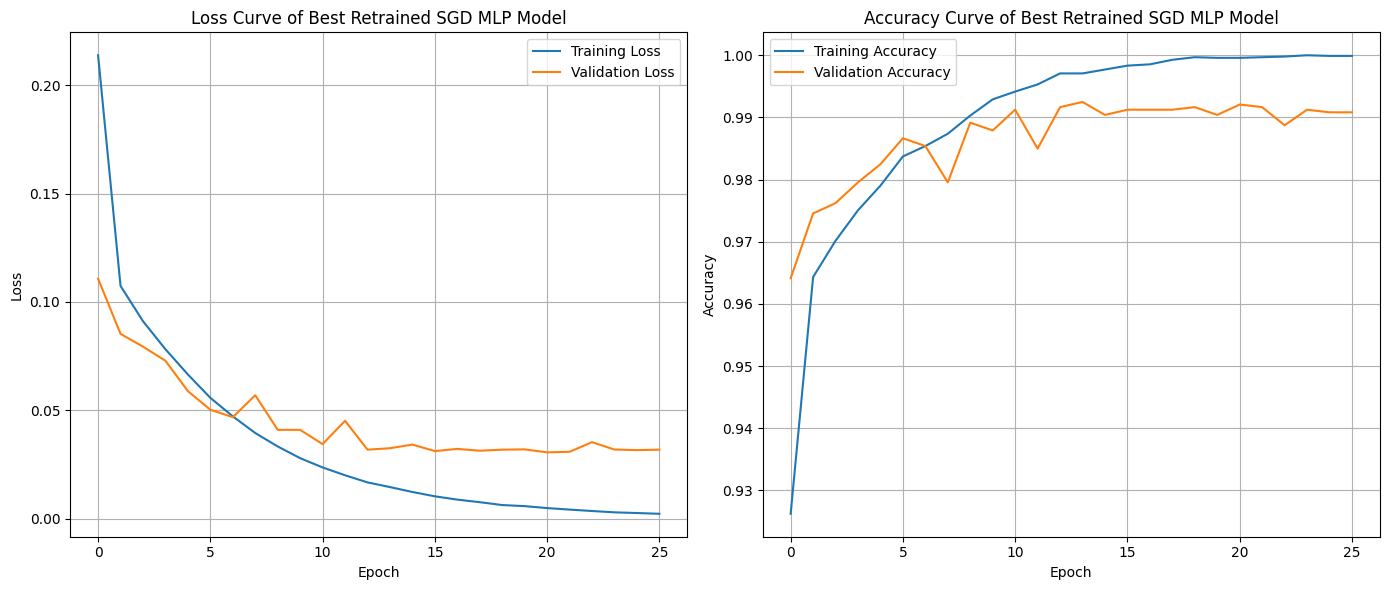

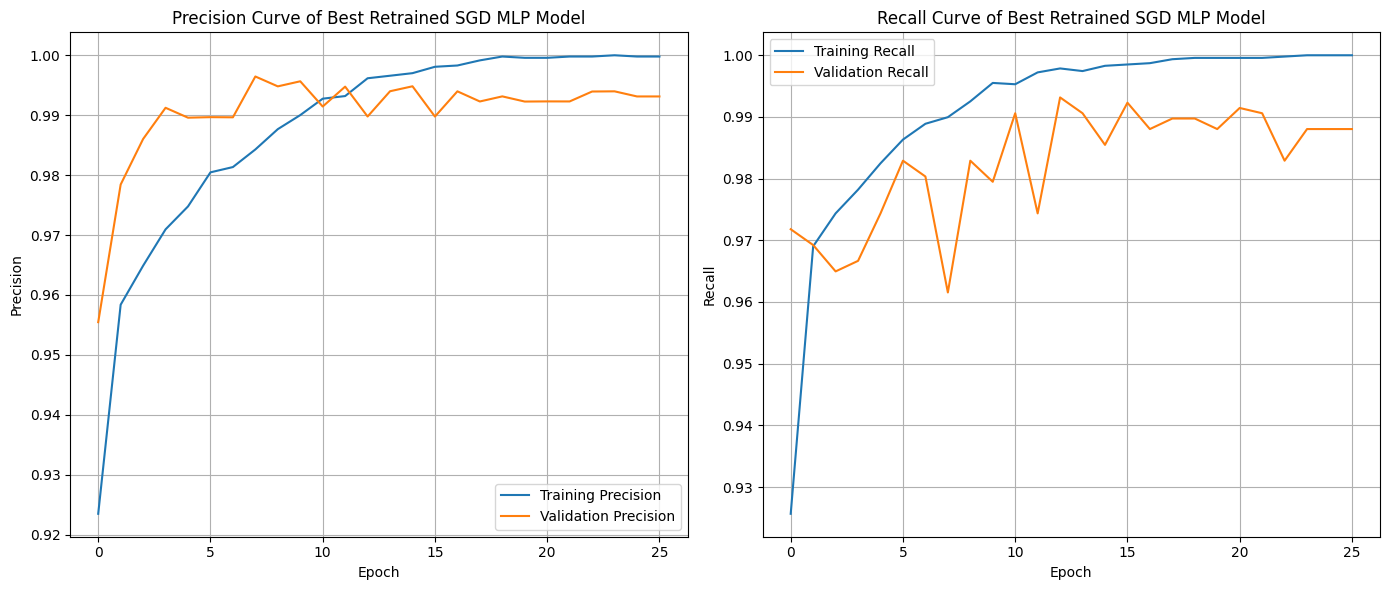

In [ ]:
print("\n--- Generating Graphs for the Best Retrained SGD Model ---")

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(history_best_sgd_retrained.history['loss'], label='Training Loss')
plt.plot(history_best_sgd_retrained.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve of Best Retrained SGD MLP Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history_best_sgd_retrained.history['accuracy'], label='Training Accuracy')
plt.plot(history_best_sgd_retrained.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve of Best Retrained SGD MLP Model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(history_best_sgd_retrained.history['precision_metric'], label='Training Precision')
plt.plot(history_best_sgd_retrained.history['val_precision_metric'], label='Validation Precision')
plt.title('Precision Curve of Best Retrained SGD MLP Model')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history_best_sgd_retrained.history['recall_metric'], label='Training Recall')
plt.plot(history_best_sgd_retrained.history['val_recall_metric'], label='Validation Recall')
plt.title('Recall Curve of Best Retrained SGD MLP Model')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


--- Generating Confusion Matrix for Best Retrained SGD MLP Model ---


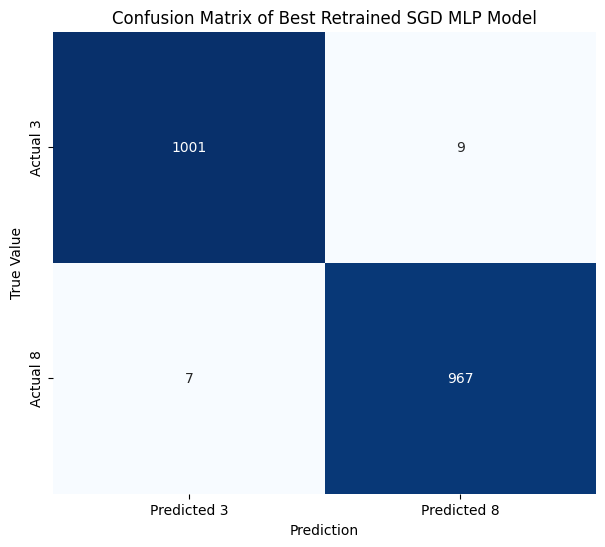

In [ ]:
print("\n--- Generating Confusion Matrix for Best Retrained SGD MLP Model ---")
cm_sgd_final_retrained = final_sgd_eval_metrics_retrained['confusion_matrix']
plt.figure(figsize=(7, 6))
sns.heatmap(cm_sgd_final_retrained, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 3', 'Predicted 8'], yticklabels=['Actual 3', 'Actual 8'])
plt.title('Confusion Matrix of Best Retrained SGD MLP Model')
plt.xlabel('Prediction')
plt.ylabel('True Value')
plt.show()


--- Generating ROC Curve for the Best Retrained SGD Model ---


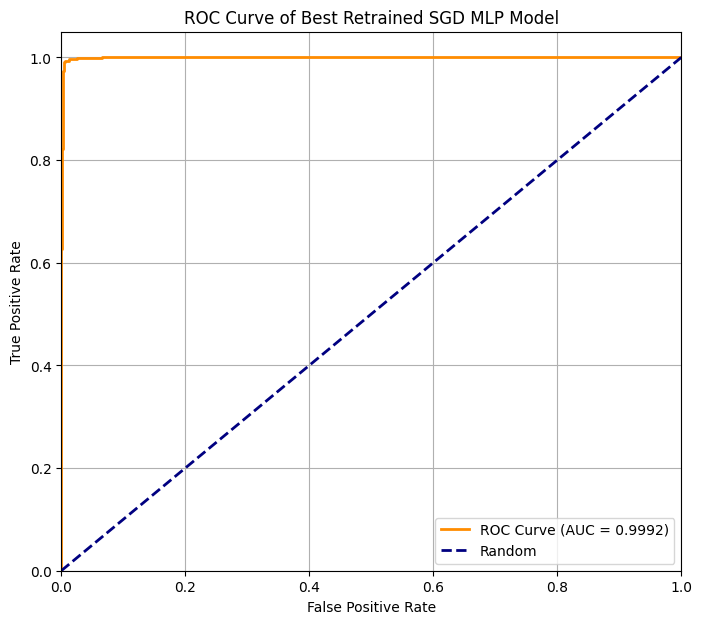

In [ ]:
print("\n--- Generating ROC Curve for the Best Retrained SGD Model ---")
y_pred_proba_sgd_retrained = final_sgd_model_retrained.predict(x_test_final, verbose=0).flatten()
fpr_sgd_retrained, tpr_sgd_retrained, thresholds_sgd_retrained = roc_curve(y_test_final, y_pred_proba_sgd_retrained)
roc_auc_sgd_retrained = auc(fpr_sgd_retrained, tpr_sgd_retrained)

plt.figure(figsize=(8, 7))
plt.plot(fpr_sgd_retrained, tpr_sgd_retrained, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc_sgd_retrained:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of Best Retrained SGD MLP Model')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


--- Generating Graphs for the Best Retrained Adam Model ---


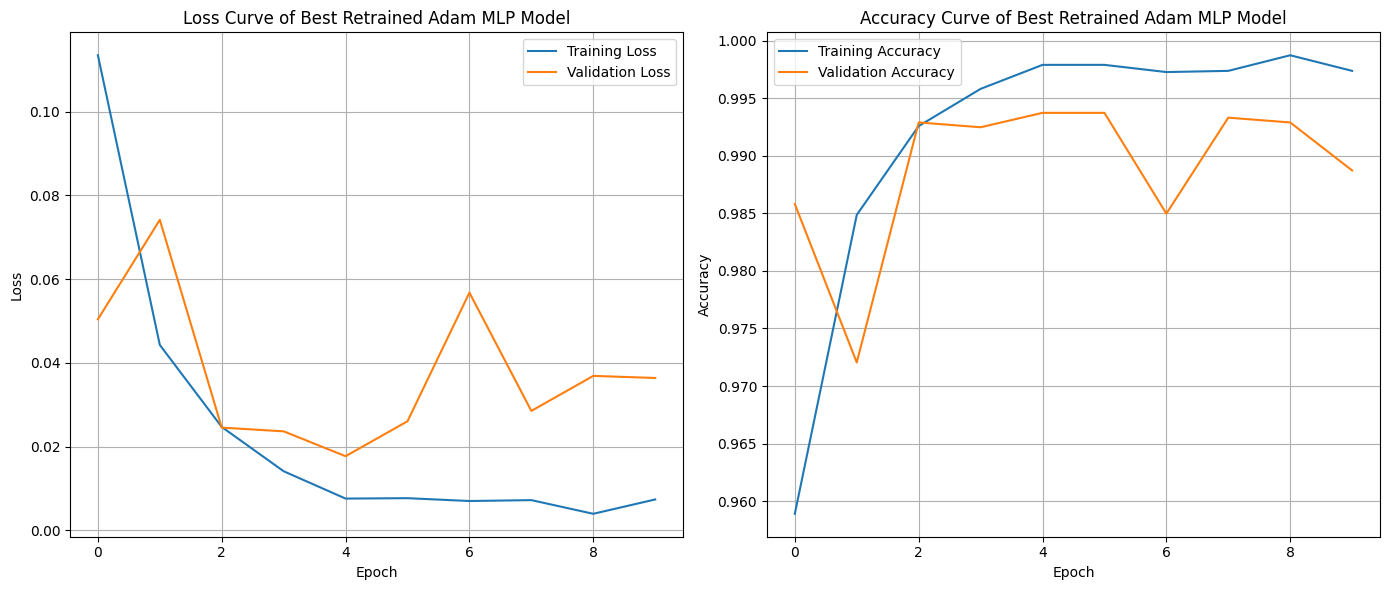

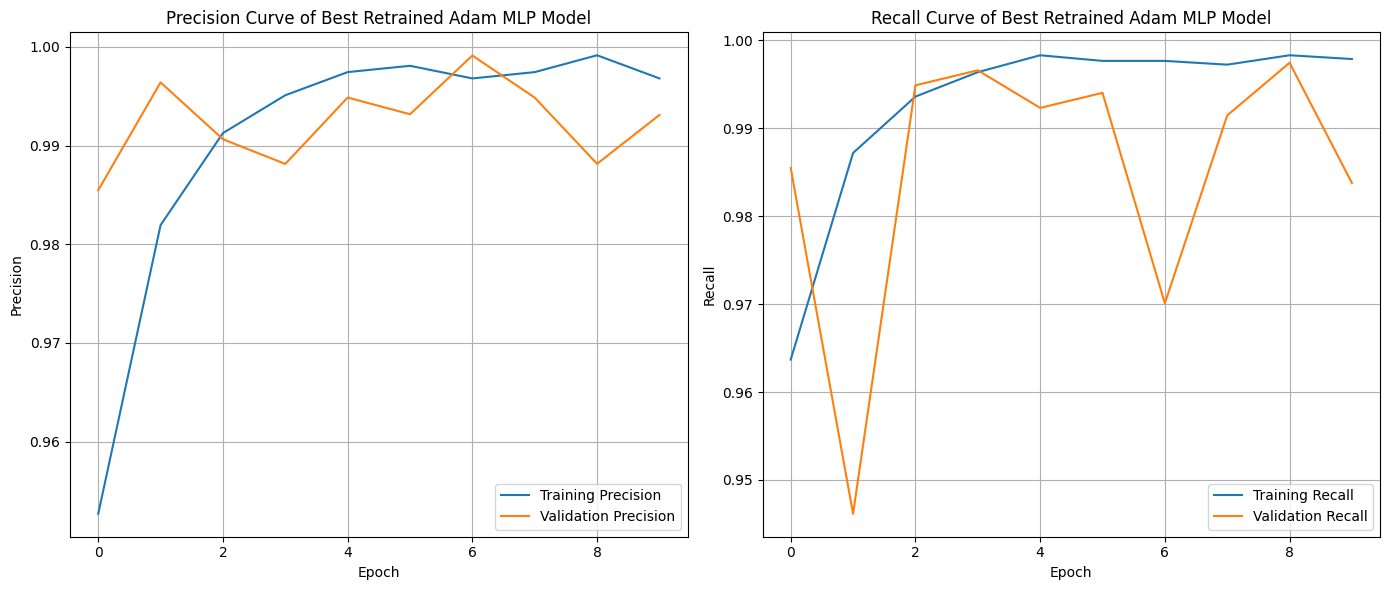

In [ ]:
print("\n--- Generating Graphs for the Best Retrained Adam Model ---")

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(history_best_adam_retrained.history['loss'], label='Training Loss')
plt.plot(history_best_adam_retrained.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve of Best Retrained Adam MLP Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history_best_adam_retrained.history['accuracy'], label='Training Accuracy')
plt.plot(history_best_adam_retrained.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve of Best Retrained Adam MLP Model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(history_best_adam_retrained.history['precision_metric'], label='Training Precision')
plt.plot(history_best_adam_retrained.history['val_precision_metric'], label='Validation Precision')
plt.title('Precision Curve of Best Retrained Adam MLP Model')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history_best_adam_retrained.history['recall_metric'], label='Training Recall')
plt.plot(history_best_adam_retrained.history['val_recall_metric'], label='Validation Recall')
plt.title('Recall Curve of Best Retrained Adam MLP Model')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


--- Generating Confusion Matrix for the Best Retrained Adam Model ---


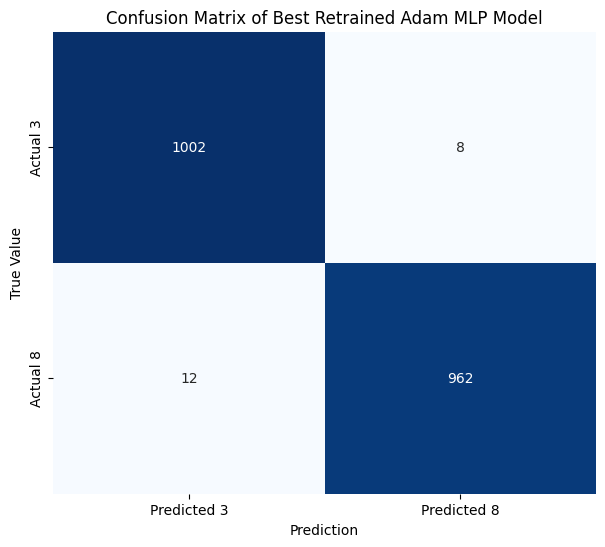

In [ ]:
print("\n--- Generating Confusion Matrix for the Best Retrained Adam Model ---")
cm_adam_final_retrained = final_adam_eval_metrics_retrained['confusion_matrix']
plt.figure(figsize=(7, 6))
sns.heatmap(cm_adam_final_retrained, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 3', 'Predicted 8'], yticklabels=['Actual 3', 'Actual 8'])
plt.title('Confusion Matrix of Best Retrained Adam MLP Model')
plt.xlabel('Prediction')
plt.ylabel('True Value')
plt.show()


--- Generating ROC Curve for the Best Retrained Adam Model ---


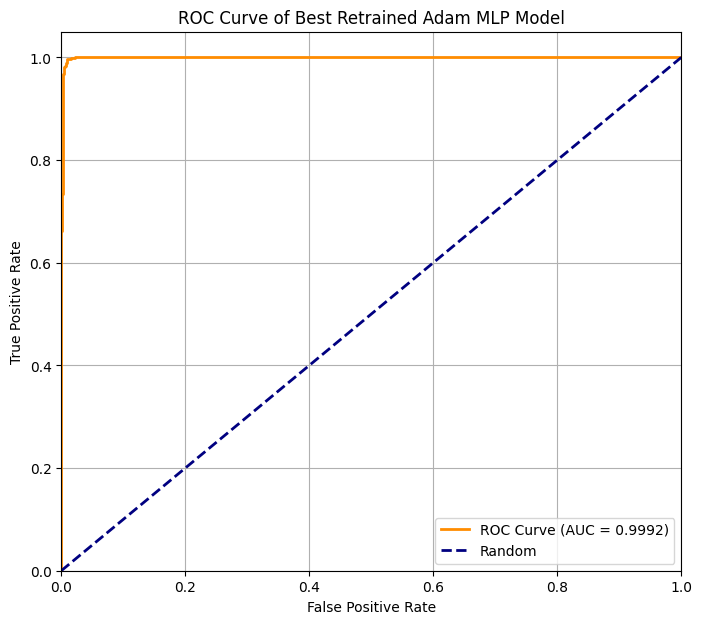

In [ ]:
print("\n--- Generating ROC Curve for the Best Retrained Adam Model ---")
y_pred_proba_adam_retrained = final_adam_model_retrained.predict(x_test_final, verbose=0).flatten()
fpr_adam_retrained, tpr_adam_retrained, thresholds_adam_retrained = roc_curve(y_test_final, y_pred_proba_adam_retrained)
roc_auc_adam_retrained = auc(fpr_adam_retrained, tpr_adam_retrained)

plt.figure(figsize=(8, 7))
plt.plot(fpr_adam_retrained, tpr_adam_retrained, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc_adam_retrained:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of Best Retrained Adam MLP Model')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


--- Generating Graphs for Final SGD Experiments (Robustness Check) ---


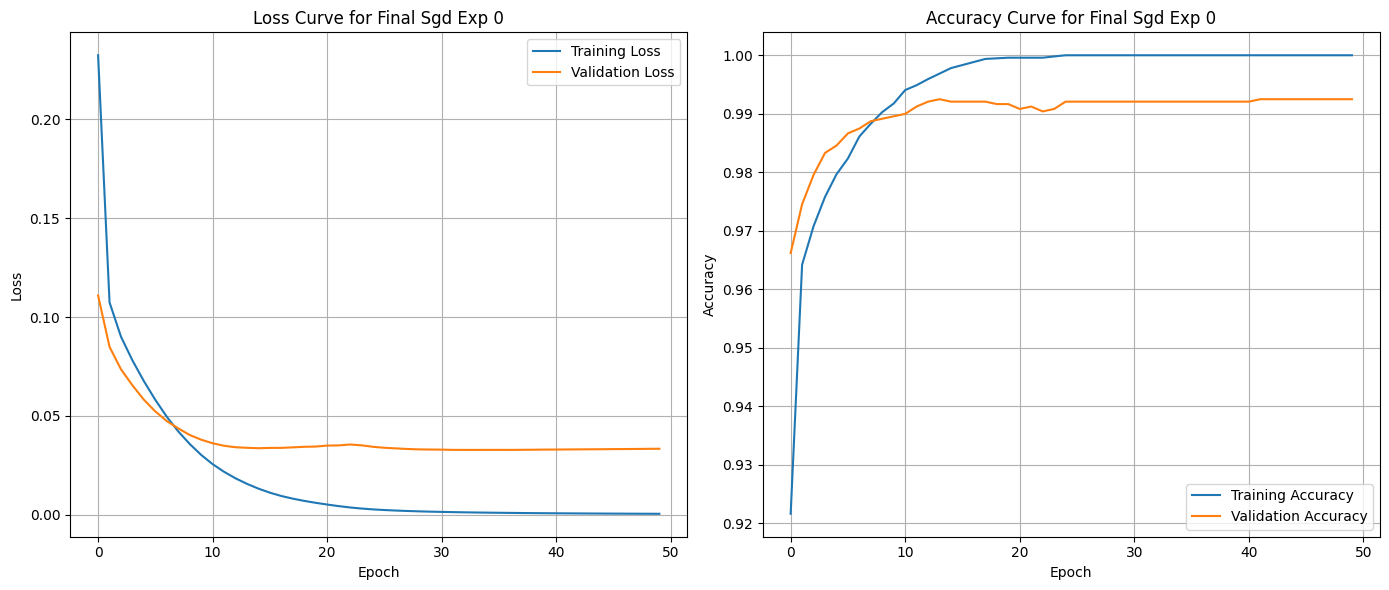

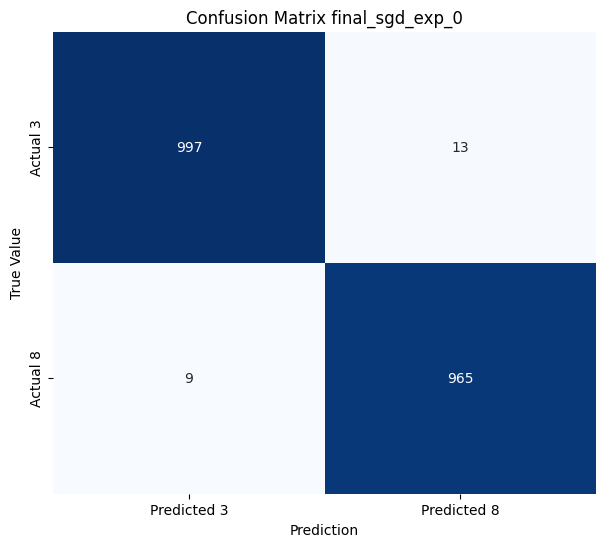

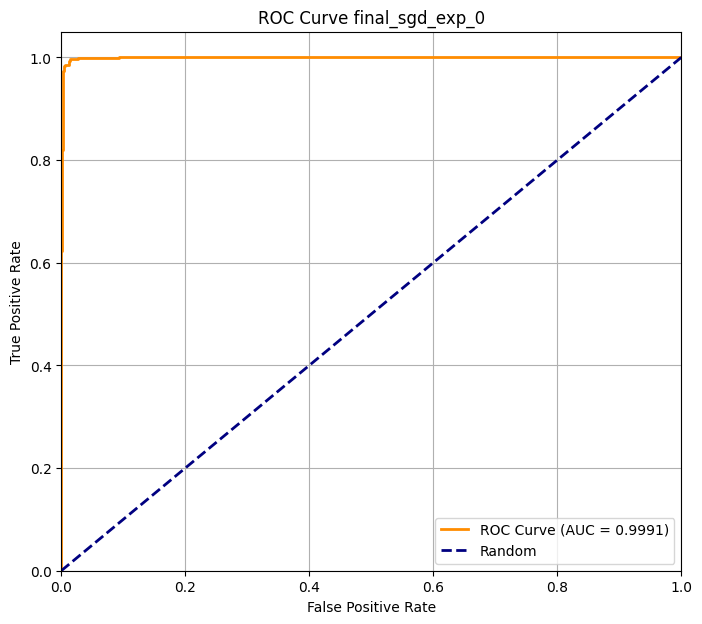

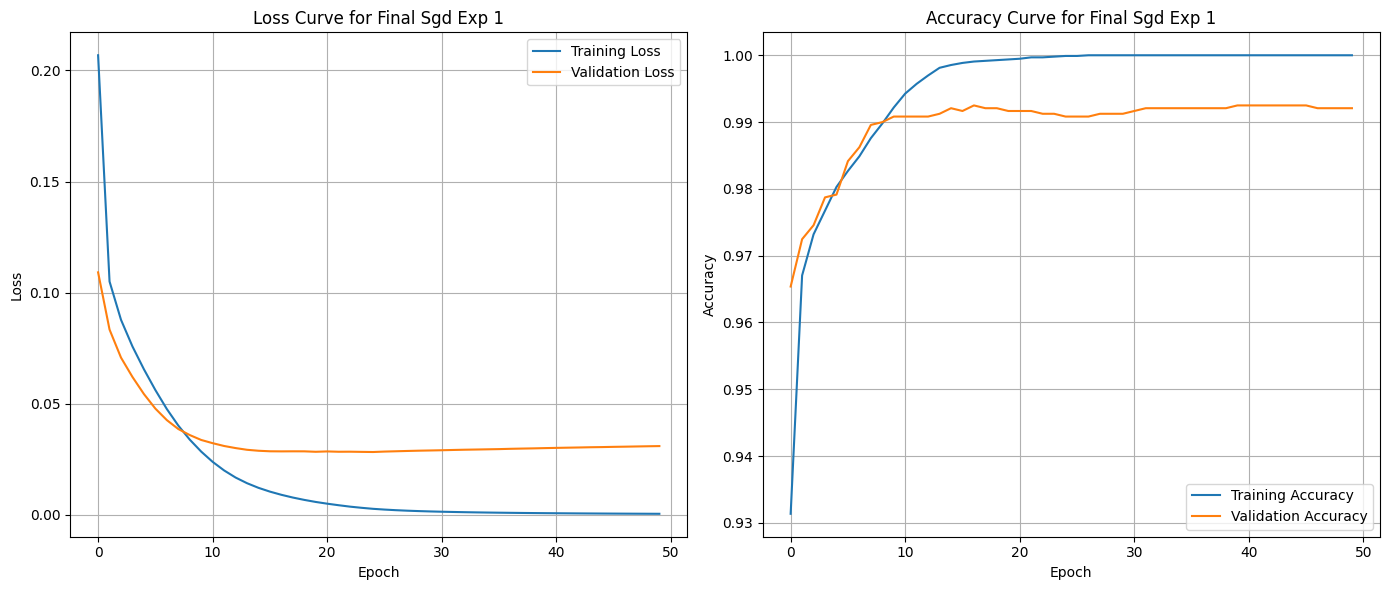

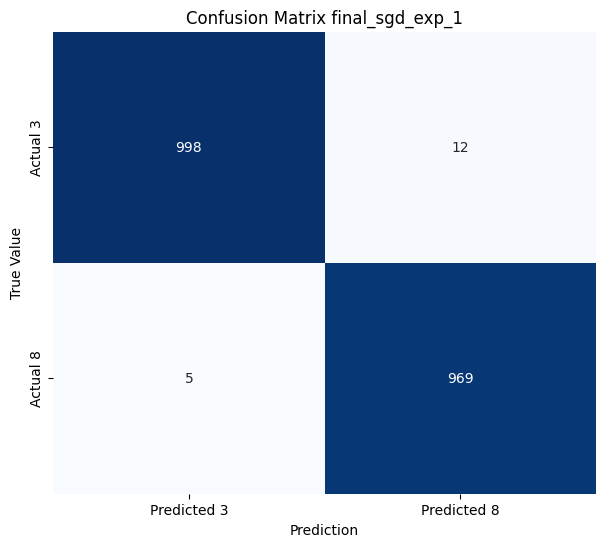

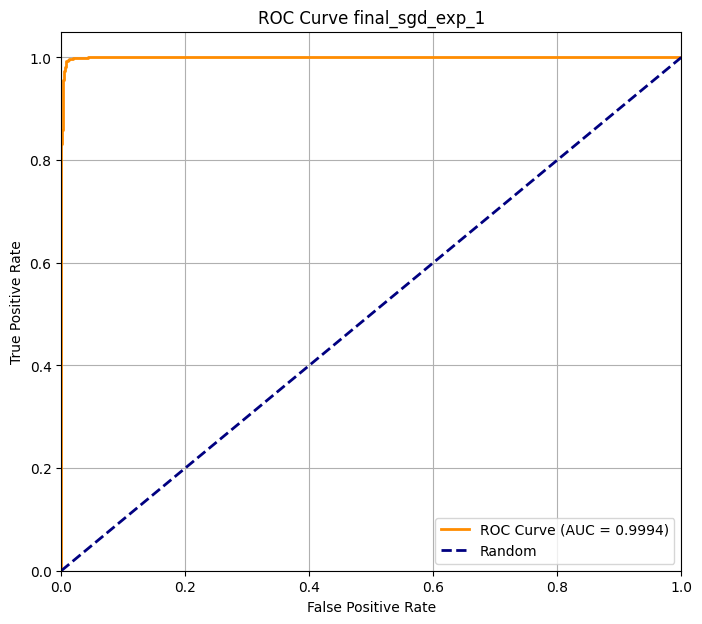

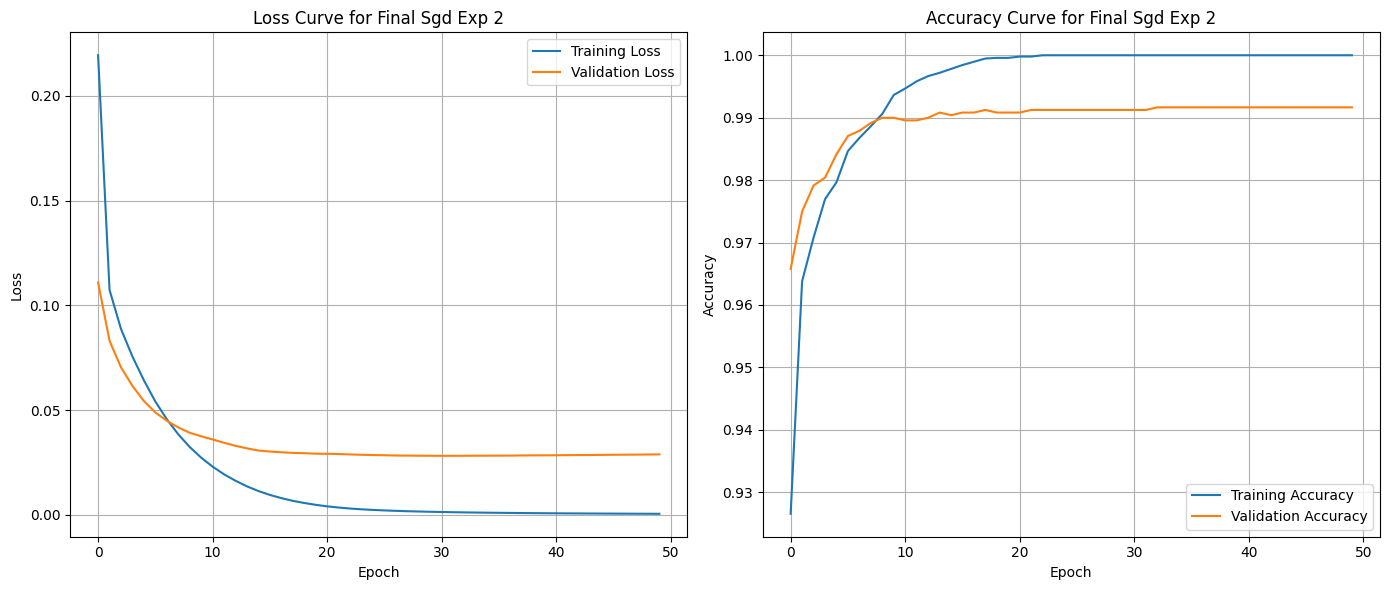

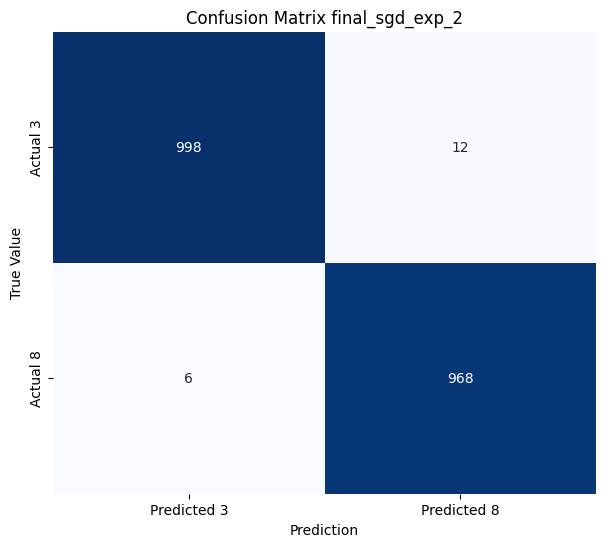

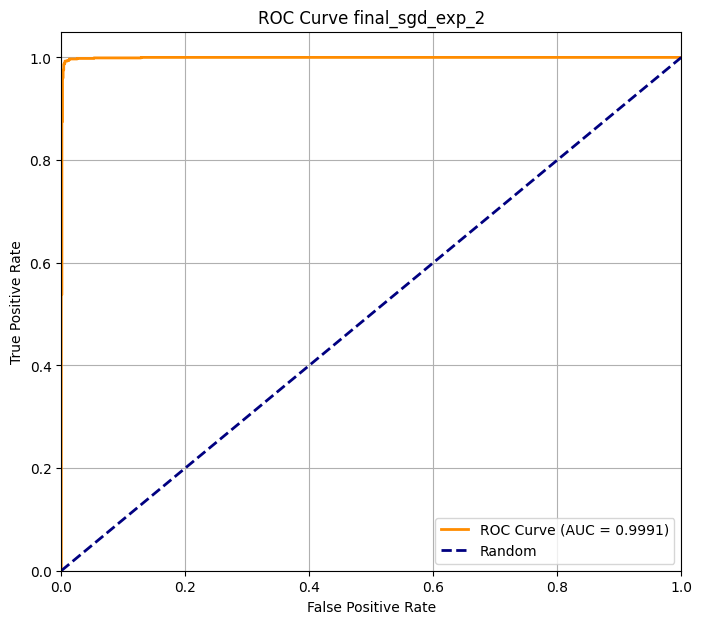

In [ ]:
print("\n--- Generating Graphs for Final SGD Experiments (Robustness Check) ---")
for i, results in enumerate(all_final_sgd_results):
    exp_name = f"final_sgd_exp_{i}"
    history = all_final_sgd_histories[exp_name]
    model_for_roc = all_final_sgd_models[exp_name]

    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Loss Curve for {exp_name.replace("_", " ").title()}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Accuracy Curve for {exp_name.replace("_", " ").title()}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


    if ('precision_metric' in history.history and 'val_precision_metric' in history.history and
        'recall_metric' in history.history and 'val_recall_metric' in history.history):

        plt.figure(figsize=(14, 6))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['precision_metric'], label='Training Precision')
        plt.plot(history.history['val_precision_metric'], label='Validation Precision')
        plt.title(f'Precision Curve (Metric) for {exp_name.replace("_", " ").title()}')
        plt.xlabel('Epoch')
        plt.ylabel('Precision')
        plt.legend()
        plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.plot(history.history['recall_metric'], label='Training Recall')
        plt.plot(history.history['val_recall_metric'], label='Validation Recall')
        plt.title(f'Recall Curve for {exp_name.replace("_", " ").title()}')
        plt.xlabel('Epoch')
        plt.ylabel('Recall')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    else:
        print(f"Warning: Precision/Recall metrics (precision_metric, recall_metric) not found in history for {exp_name}. Available keys: {history.history.keys()}")

    plt.figure(figsize=(7, 6))
    sns.heatmap(results['confusion_matrix'], annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Predicted 3', 'Predicted 8'], yticklabels=['Actual 3', 'Actual 8'])
    plt.title(f'Confusion Matrix {exp_name}')
    plt.xlabel('Prediction')
    plt.ylabel('True Value')
    plt.show()

    y_pred_proba = model_for_roc.predict(x_test_final, verbose=0).flatten()
    fpr, tpr, _ = roc_curve(y_test_final, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 7))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve {exp_name}')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()


--- Generating Graphs for Final Adam Experiments (Robustness Check) ---


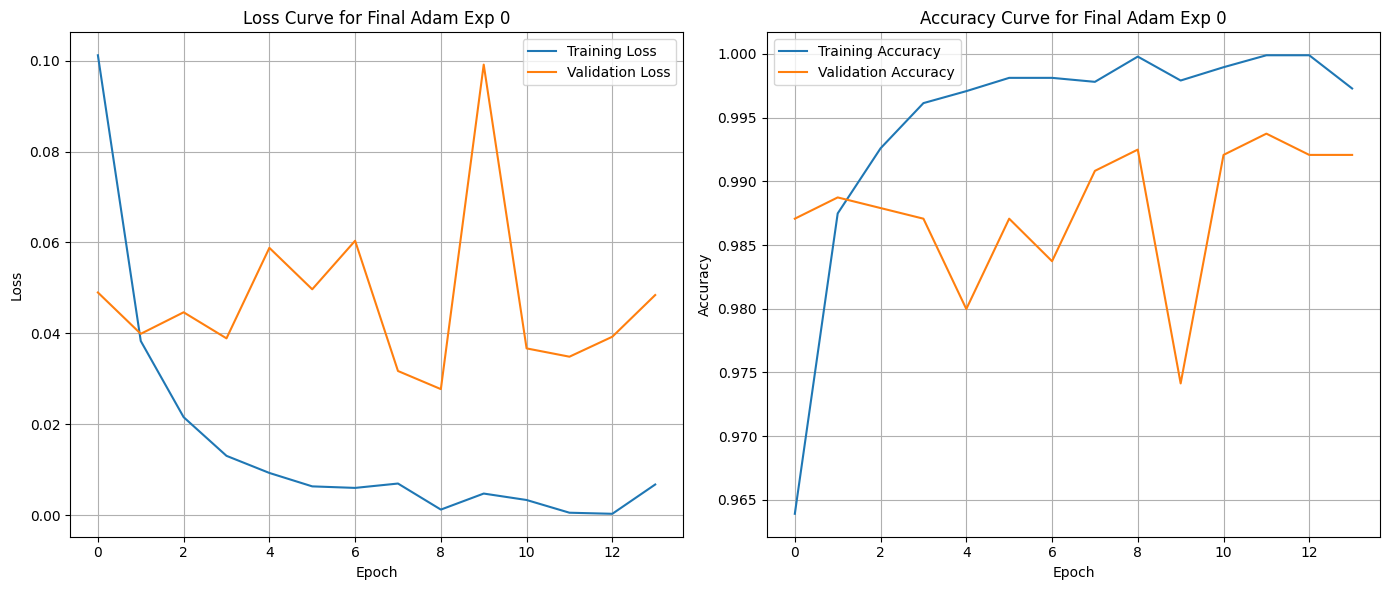

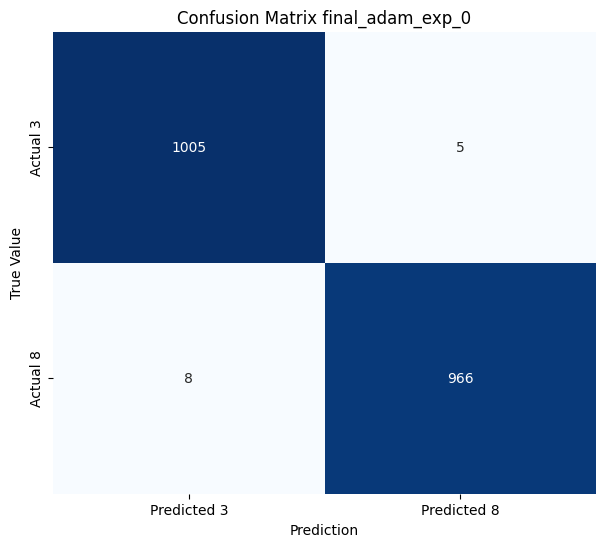

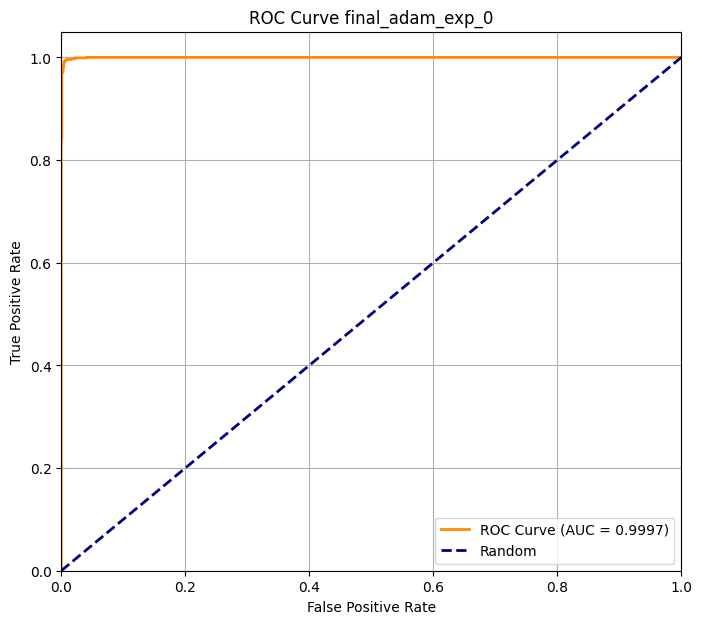

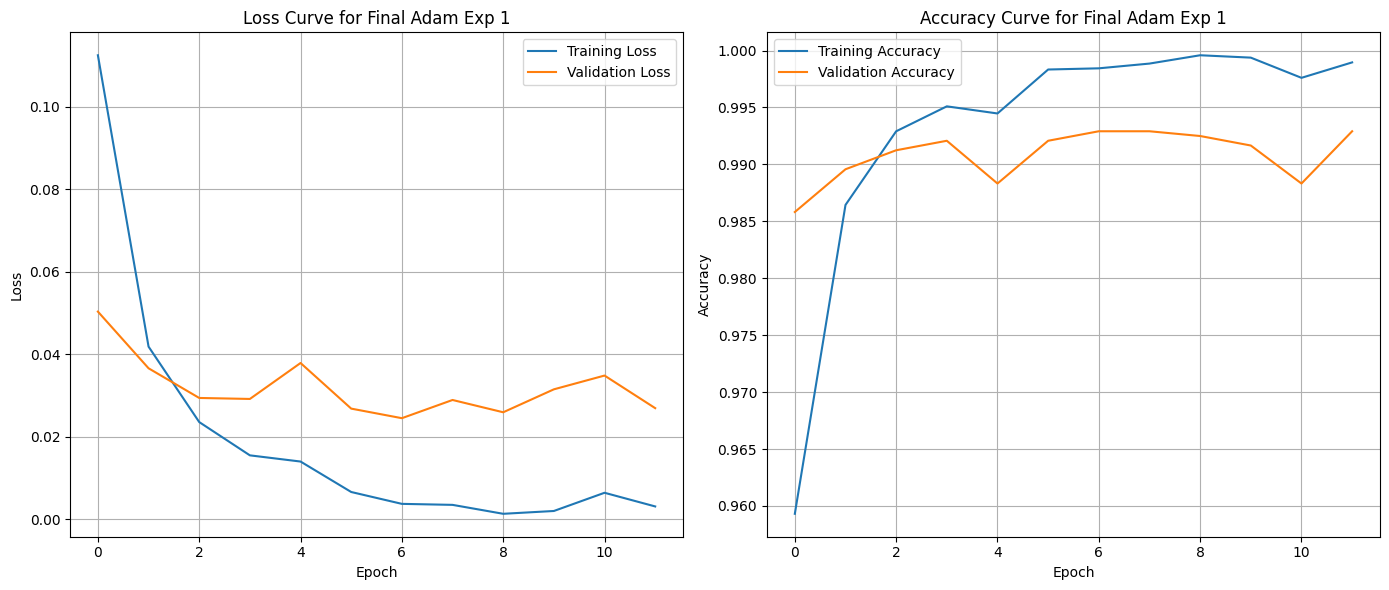

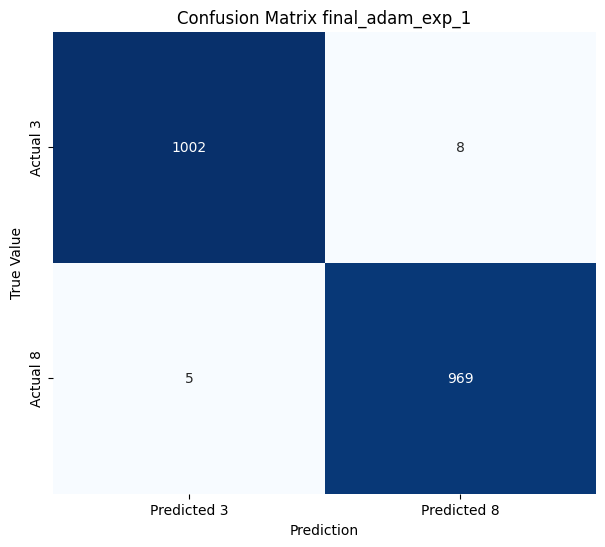

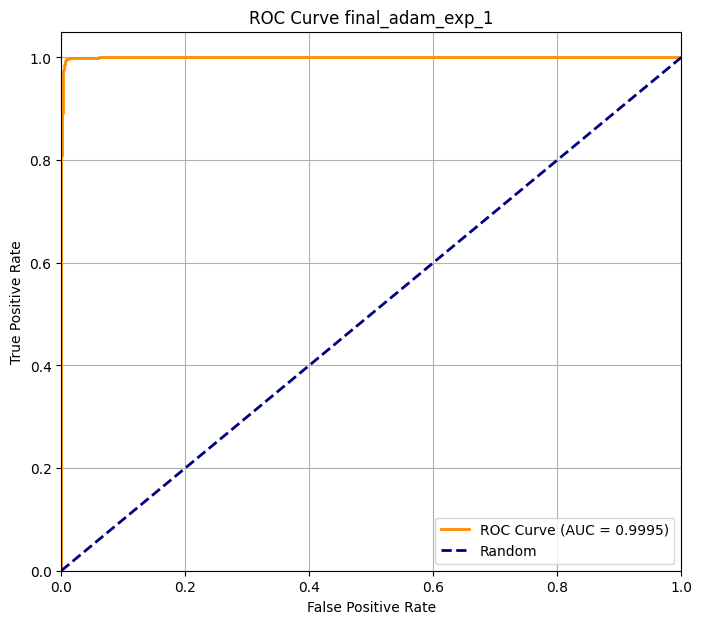

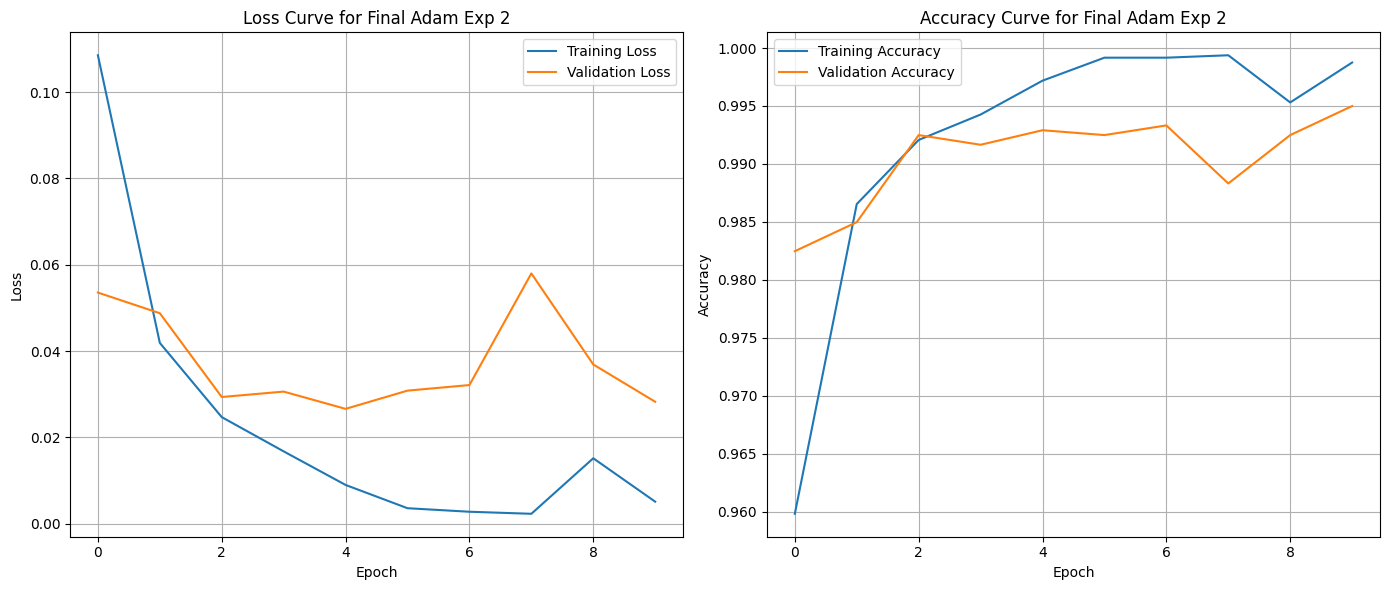

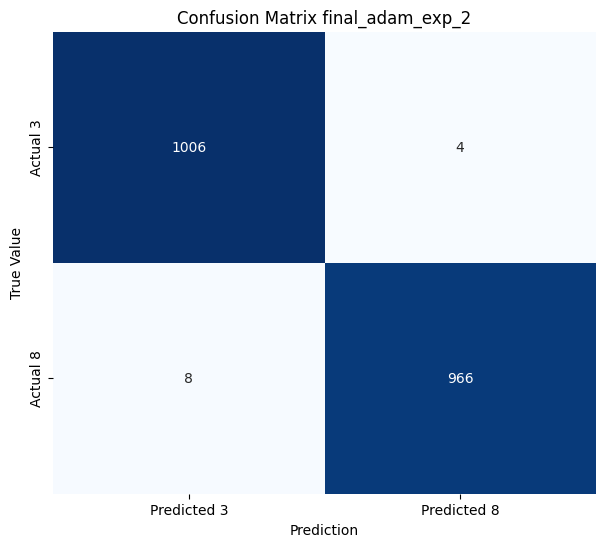

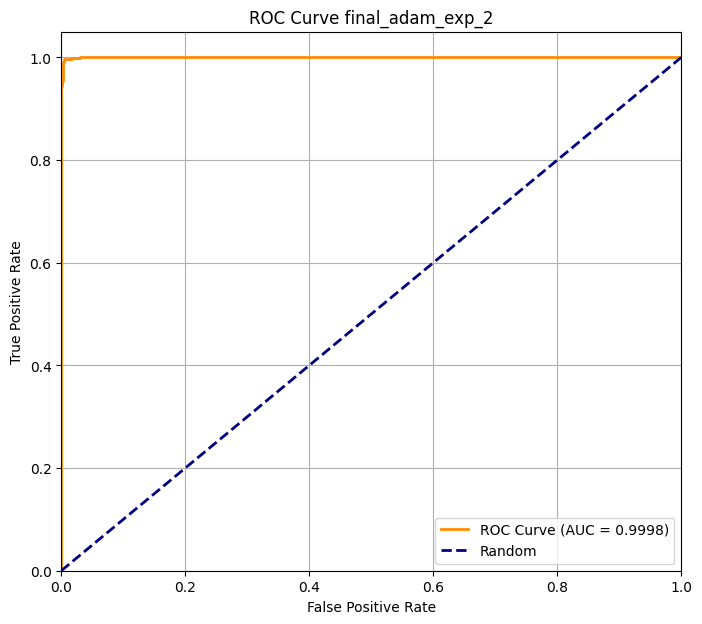

In [ ]:
print("\n--- Generating Graphs for Final Adam Experiments (Robustness Check) ---")
for i, results in enumerate(all_final_adam_results):
    exp_name = f"final_adam_exp_{i}"
    history = all_final_adam_histories[exp_name]
    model_for_roc = all_final_adam_models[exp_name]

    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Loss Curve for {exp_name.replace("_", " ").title()}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Accuracy Curve for {exp_name.replace("_", " ").title()}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    if ('precision_metric' in history.history and 'val_precision_metric' in history.history and
        'recall_metric' in history.history and 'val_recall_metric' in history.history):

        plt.figure(figsize=(14, 6))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['precision_metric'], label='Training Precision')
        plt.plot(history.history['val_precision_metric'], label='Validation Precision')
        plt.title(f'Precision Curve (Metric) for {exp_name.replace("_", " ").title()}')
        plt.xlabel('Epoch')
        plt.ylabel('Precision')
        plt.legend()
        plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.plot(history.history['recall_metric'], label='Training Recall')
        plt.plot(history.history['val_recall_metric'], label='Validation Recall')
        plt.title(f'Recall Curve for {exp_name.replace("_", " ").title()}')
        plt.xlabel('Epoch')
        plt.ylabel('Recall')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    else:
        print(f"Warning: Precision/Recall metrics (precision_metric, recall_metric) not found in history for {exp_name}. Available keys: {history.history.keys()}")

    plt.figure(figsize=(7, 6))
    sns.heatmap(results['confusion_matrix'], annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Predicted 3', 'Predicted 8'], yticklabels=['Actual 3', 'Actual 8'])
    plt.title(f'Confusion Matrix {exp_name}')
    plt.xlabel('Prediction')
    plt.ylabel('True Value')
    plt.show()

    y_pred_proba = model_for_roc.predict(x_test_final, verbose=0).flatten()
    fpr, tpr, _ = roc_curve(y_test_final, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 7))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve {exp_name}')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()